In [1]:
# Post galfit analysis

In [1]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import pickle
import os
from __future__ import division
import fnmatch
import multiprocessing as mp
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
# Make plots readable
# Update plot params
params = {'legend.fontsize': 12,
	  'figure.figsize': (6,5),
	 'axes.labelsize': 14,
	 'axes.titlesize':12,
	 'xtick.labelsize':12,
	 'ytick.labelsize':12,
    'font.family': 'Helvetica',
     'mathtext.default': 'regular'}
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rcParams.update(params)
# plt.rc('font', family='Helvetica')

In [3]:
def plot_by_ID(ID,save_name=None,cos_df=None,catalog=False):
    if not save_name:
        print 'provide a save_name...'
        return
    tdir = '/data/emiln/XLSSU122/analysis/3dhst/galfit_results/'+str(ID)
    
#     ttdf = pd.read_csv('COSMOS_test_galfit_results_'+save_name+'.csv')
    ttdf = pd.read_csv('results/'+save_name+'.csv')
    print 'ID:',ID
    print 'ttdf[ID]',ttdf['ID']
#     print ttdf[ttdf['ID'] == ID]
#     print ID
    try: 
        oimg = fits.open(tdir+'/out_'+save_name+'.fits')
        showme3(oimg)
    except:
        print "No model fit found. Plotting raw image from /cutout.fits"
        try:
            oimg = fits.open(tdir+'/cutout.fits')
            vm = np.percentile(oimg[0].data,99)
            plt.figure()
            plt.subplot(131)
            plt.imshow(oimg[0].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
        except:
            print "No cutout.fits file found..."
            oimg = fits.open(tdir+'/data_cps.fits')
            vm = np.percentile(oimg[0].data,99)
            plt.figure(figsize=(5,5))
            plt.subplot()
            plt.imshow(oimg[0].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
    if catalog:    
        print '\n ***CATALOG PARAMS***'
        print cos_df[cos_df['NUMBER']==ID][['q','n','re']]
    plt.show()

In [4]:
def summarize_results(galfit_file):
    df2 = pd.read_csv(galfit_file)
    print len(df2[df2['n']==-99])
    df = df2[df2['n']!=-99]

#     plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red')
    plt.xlabel('Sersic index, n')
    plt.legend()
    plt.show()
#     print np.max(cos_df['n'])

#     plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red')
    plt.xlabel('Effective radius (\'\')')
    plt.legend()
    plt.show()

#     plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red')
    plt.xlabel('Axis ratio, q')
    plt.legend()
    plt.show()
    
#     mdf = df.merge(hst_df,on='ID',suffixes=('_M','_C'))
    mdf = df.merge(zhst_df,on='ID',suffixes=('_M','_C'))
    #     print mdf.columns.values    
    kpa = cosmo.kpc_proper_per_arcmin(mdf['z']).value/60

    mdf['re_kpc'] = mdf['re']*0.06 * kpa # re[pixels] * 0.06 arcsec/pixel * kpa/arcsec
    
    mdf['F125W'] = 25.0 - 2.5 * np.log10(mdf['f_F125W'])
    mdf['F160W'] = 25.0 - 2.5 * np.log10(mdf['f_F160W'])
    mdf['F814W'] = 25.0 - 2.5 * np.log10(mdf['f_F814W'])
    
    mdf['mag_M-mag_C-1.5'] = mdf['mag'] - (mdf['F140W']-1.465)
    
    plt.scatter(mdf['F140W'],mdf['mag'],alpha=0.3)
    plt.plot([15,26],[15,26],'k--')
    plt.ylabel('measured Mag')
    plt.xlabel('catalog F140W')
    plt.xlim([21,25])
    plt.ylim([21,25])
    plt.show()
    
    plt.scatter(mdf['F140W']-1.465,mdf['mag'],alpha=0.3)
    plt.plot([15,26],[15,26],'k--')
    plt.ylabel('measured Mag')
    plt.xlabel('catalog F140W - 1.465')
    plt.xlim([21,25])
    plt.ylim([21,25])
    plt.show()
    
    return mdf

### Load data
1. Load galfit results
2. Load 3DHST data
3. Merge

136
8


/data/emiln/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


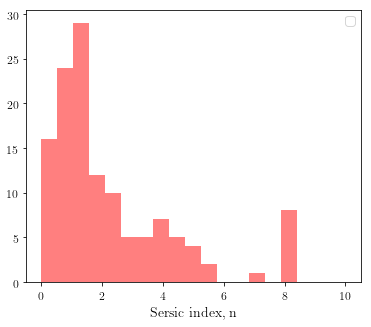

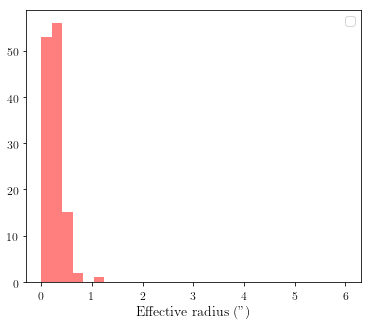

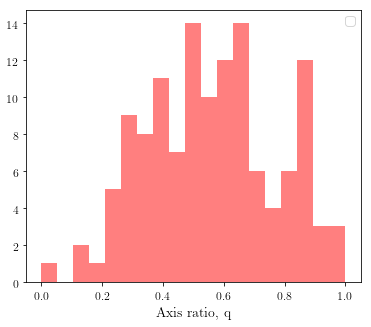

/data/emiln/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10


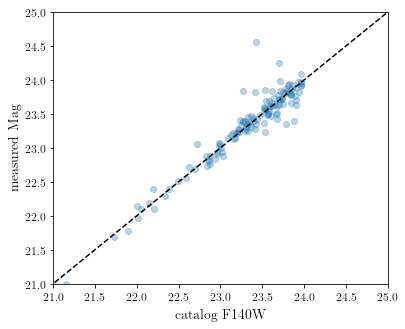

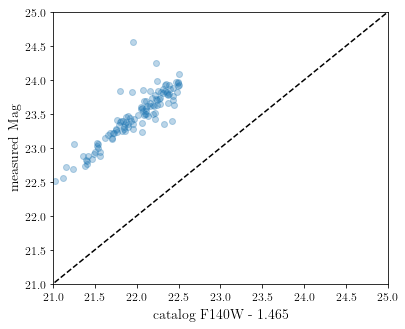

128


In [5]:
zthresh=0.1
# save_name = '3dhst_highz_thresh0.3_mag24_ZPCORR_data_cps_sigma_rms_meanexp_cps_w10HLR_3DHST_F140W_PSF_5min_CONV50_CONSTR_DYNMAG_TEST'
save_name = '3dhst_highz_thresh0.1_mag24_ZPCORR_data_cps_sigma_rms_meanexp_cps_w10HLR_3DHST_F140W_PSF_5min_CONV50_CONSTR_DYNMAG'

zhst_df = pd.read_csv('/data/emiln/XLSSU122/analysis/3dhst/catalogs/merged_highz_thresh'+str(zthresh)+'.cat')
zhst_df

zhst_df['X'] = zhst_df['x']
zhst_df['Y'] = zhst_df['y']
zhst_df['ID'] = zhst_df['id']
zhst_df['RA'] = zhst_df['ra']
zhst_df['DEC'] = zhst_df['dec']

print len(zhst_df)

mdf = summarize_results('results/'+save_name+'.csv')

print(len(mdf))

In [6]:
print len(zhst_df)
print len(mdf)

136
128


In [7]:
mdf.columns.values

array(['ID', 'ra_M', 'dec_M', 're', 're_err', 'ar', 'ar_err', 'n',
       'n_err', 'mag', 'mag_err', 'sky', 'sky_err', 'chi2nu',
       'ErrorValue', 'id', 'x', 'y', 'ra_C', 'dec_C', 'faper_F160W',
       'eaper_F160W', 'faper_F140W', 'eaper_F140W', 'f_F160W', 'e_F160W',
       'w_F160W', 'f_U', 'e_U', 'w_U', 'f_B', 'e_B', 'w_B', 'f_G', 'e_G',
       'w_G', 'f_V', 'e_V', 'w_V', 'f_F606W', 'e_F606W', 'w_F606W', 'f_R',
       'e_R', 'w_R', 'f_Rp', 'e_Rp', 'w_Rp', 'f_I', 'e_I', 'w_I', 'f_Ip',
       'e_Ip', 'w_Ip', 'f_F814W', 'e_F814W', 'w_F814W', 'f_Z', 'e_Z',
       'w_Z', 'f_Zp', 'e_Zp', 'w_Zp', 'f_UVISTA_Y', 'e_UVISTA_Y',
       'w_UVISTA_Y', 'f_F125W', 'e_F125W', 'w_F125W', 'f_J1', 'e_J1',
       'w_J1', 'f_J2', 'e_J2', 'w_J2', 'f_J3', 'e_J3', 'w_J3', 'f_J',
       'e_J', 'w_J', 'f_UVISTA_J', 'e_UVISTA_J', 'w_UVISTA_J', 'f_F140W',
       'e_F140W', 'w_F140W', 'f_H1', 'e_H1', 'w_H1', 'f_H2', 'e_H2',
       'w_H2', 'f_H', 'e_H', 'w_H', 'f_UVISTA_H', 'e_UVISTA_H',
       'w_UVISTA_H', '

### Split early & late-type gals

In [8]:
# Make a histogram in color space color coded by average SSFR
# Is there a dividing line?

# Filter those without ssfr measurement
print len(mdf)
mdf = mdf[mdf['lssfr']>-99]
print len(mdf)

128
126


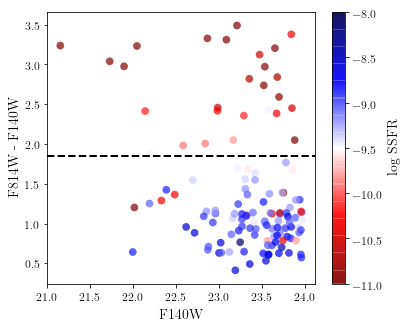

In [9]:
reds = plt.get_cmap("Reds")
seismic = plt.get_cmap("seismic_r")
ssfr_thresh = -9.6
plt.scatter(mdf['F140W'],mdf['F814W'] - mdf['F140W'],c=mdf['lssfr'],cmap=seismic,s=60,edgecolors='none',alpha=0.7,vmin=-11,vmax=-8)
plt.xlabel('F140W')
plt.ylabel('F814W - F140W')
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(r'log SSFR', fontsize=14)
# plt.ylim([0,2])
# plt.grid()
plt.axhline(1.85,color='black',linestyle='--',linewidth=2)
plt.show()

nan
nan
-8.58330781488395
0.96667687404642
-8.748773721666495
0.9004905113334019
-8.910405866118392
0.8358376535526432
-9.066007806300773
0.7735968774796909
-9.230835006988741
0.7076659972045036
-9.41558334650046
0.633766661399816
-9.823167944127878
0.47073282234884883
-10.244691405490645
0.30212343780374196
-10.054462984093146
0.37821480636274174
-10.882292605166592
0.04708295793336319
-11.013534957844476
-0.005413983137790268
-11.016971296289718
-0.006788518515887176
-11.23
-0.09200000000000016
nan
nan


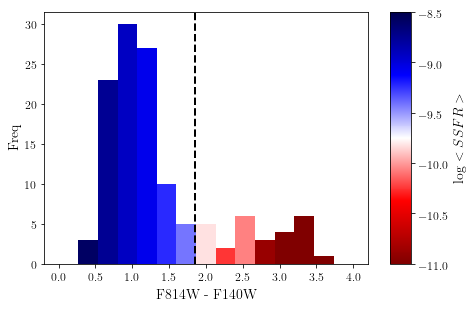

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib as mpl

cmap = plt.get_cmap("seismic_r")
vmax = -8.5
vmin = -11
norm = Normalize(vmin=vmin, vmax=vmax)

mdf['color'] = mdf['F814W'] - mdf['F140W']

fig = plt.figure()
ax = fig.add_axes([0.05, 0.2, 0.75, 0.7])
ax1 = fig.add_axes([0.85, 0.2, 0.05, 0.7])

# cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical',
#                                label='mean prob no source')

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=seismic,
#                                 vmin=vmin,
#                                 vmax=vmax,
                                norm=norm,
                                orientation='vertical',
                               label='log $<SSFR>$')

n, bins, patches = ax.hist(mdf['color'],bins=np.linspace(0,4,16))
ax.set_xscale('linear')
ax.axvline(1.85,color='black',linestyle='--',linewidth=2)

for i,p in enumerate(patches):
    c = np.log10(np.mean(10**(mdf[(mdf['color']>bins[i]) & (mdf['color']<bins[i+1])]['lssfr'])))
    print c
    c = (c-vmin)/(vmax-vmin)
    print c
#     c=0.4
    plt.setp(p,'facecolor',cmap(c))

ax.set_xlabel('F814W - F140W')
ax.set_ylabel('Freq')
plt.show()

### Fit early and late-type mass-size relation w/o errors

In [13]:
print len(mdf)
mdf = mdf[mdf['lssfr']>-90]
print len(mdf)

print len(mdf)
print mdf.columns.values
print len(mdf[mdf['re']==0.3])
mdf = mdf[mdf['re']!=0.3]
mdf = mdf[mdf['use_phot']==1]
print len(mdf)
mdf = mdf[mdf['flags']<2]
print len(mdf)
mdf = mdf[mdf['contam_flag']<1]
print len(mdf)

126
126
126
['ID' 'ra_M' 'dec_M' 're' 're_err' 'ar' 'ar_err' 'n' 'n_err' 'mag'
 'mag_err' 'sky' 'sky_err' 'chi2nu' 'ErrorValue' 'id' 'x' 'y' 'ra_C'
 'dec_C' 'faper_F160W' 'eaper_F160W' 'faper_F140W' 'eaper_F140W' 'f_F160W'
 'e_F160W' 'w_F160W' 'f_U' 'e_U' 'w_U' 'f_B' 'e_B' 'w_B' 'f_G' 'e_G' 'w_G'
 'f_V' 'e_V' 'w_V' 'f_F606W' 'e_F606W' 'w_F606W' 'f_R' 'e_R' 'w_R' 'f_Rp'
 'e_Rp' 'w_Rp' 'f_I' 'e_I' 'w_I' 'f_Ip' 'e_Ip' 'w_Ip' 'f_F814W' 'e_F814W'
 'w_F814W' 'f_Z' 'e_Z' 'w_Z' 'f_Zp' 'e_Zp' 'w_Zp' 'f_UVISTA_Y'
 'e_UVISTA_Y' 'w_UVISTA_Y' 'f_F125W' 'e_F125W' 'w_F125W' 'f_J1' 'e_J1'
 'w_J1' 'f_J2' 'e_J2' 'w_J2' 'f_J3' 'e_J3' 'w_J3' 'f_J' 'e_J' 'w_J'
 'f_UVISTA_J' 'e_UVISTA_J' 'w_UVISTA_J' 'f_F140W' 'e_F140W' 'w_F140W'
 'f_H1' 'e_H1' 'w_H1' 'f_H2' 'e_H2' 'w_H2' 'f_H' 'e_H' 'w_H' 'f_UVISTA_H'
 'e_UVISTA_H' 'w_UVISTA_H' 'f_K' 'e_K' 'w_K' 'f_Ks' 'e_Ks' 'w_Ks'
 'f_UVISTA_Ks' 'e_UVISTA_Ks' 'w_UVISTA_Ks' 'f_IRAC1' 'e_IRAC1' 'w_IRAC1'
 'f_IRAC2' 'e_IRAC2' 'w_IRAC2' 'f_IRAC3' 'e_IRAC3' 'w_IRAC3' 'f_IRAC4

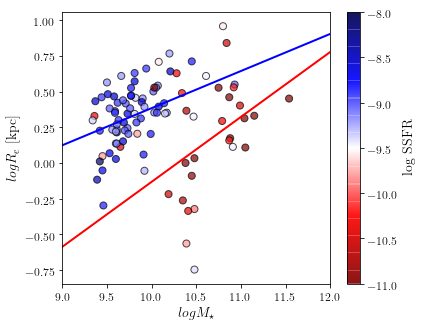

0.26008891026922515 -2.216351975647803 0.33978423333270663 0.0030581252524490995 0.08484236011581124
0.45505441845674777 -4.682730998575823 0.45342122605628027 0.02606191991473384 0.1907094784857407


In [15]:
from scipy.stats import linregress
reds = plt.get_cmap("Reds")
seismic = plt.get_cmap("seismic_r")
ssfr_thresh = -9.6
color_thresh = 1.85

plt.scatter(mdf['lmass'],np.log10(mdf['re_kpc']),c=mdf['lssfr'],cmap=seismic,s=50,edgecolors='k',alpha=0.7,vmin=-11,vmax=-8)
plt.xlabel('$log M_{\star}$')
plt.ylabel('$log R_e$ [kpc]')
# plt.yscale('log')


# plt.scatter(mdf['n_M'],mdf['n_C'],c=mdf['sky'],cmap=seismic,s=50,edgecolors='k',alpha=0.7,vmin=-1,vmax=1)
# plt.plot([0,8],[0,8],'k--')
# plt.xlabel(r'Measured $n$')
# plt.ylabel(r'Catalog $n$')
# plt.xlim([0,8])
# plt.ylim([0,8])
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(r'log SSFR', fontsize=14)


# Fit lssfr < -10 and lssfr > -10
# smdf = mdf[mdf['lssfr']>ssfr_thresh]
# qmdf = mdf[mdf['lssfr']<ssfr_thresh]

qmdf = mdf[mdf['color']>color_thresh]
smdf = mdf[mdf['color']<color_thresh]

ss, si, sr, sp, sstd = linregress(smdf['lmass'],np.log10(smdf['re_kpc']))
qs, qi, qr, qp, qstd = linregress(qmdf['lmass'],np.log10(qmdf['re_kpc']))
X = np.linspace(9,12,10)
plt.plot(X,si+ss*X,linewidth=2,color='blue')
plt.plot(X,qi+qs*X,linewidth=2,color='red')
plt.xlim(9,12)
plt.show()
print ss, si, sr, sp, sstd
print qs, qi, qr, qp, qstd 

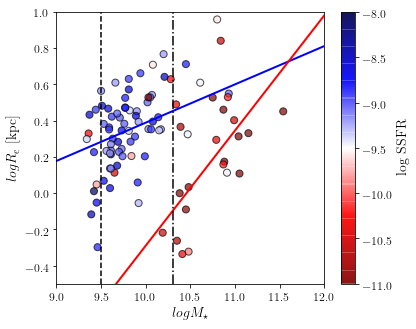

SFG slope: 0.211316048655351 SFG int: -1.7238109592878108 SFG R^2: 0.2715003302757799
0.03136413830581014 0.0959113755976041
Quiescent slope: 0.6354747719456844 Quiescent int: -6.644162735304267 Quiescent R^2: 0.5690221377278634
0.005714630684531212 0.20535069173719586
SFG fit if M>3e9. Quiescent fit if M>2e10


In [20]:
ssfr_thresh = -9.6
reds = plt.get_cmap("Reds")
seismic = plt.get_cmap("seismic_r")

plt.scatter(mdf['lmass'],np.log10(mdf['re_kpc']),c=mdf['lssfr'],cmap=seismic,s=50,edgecolors='k',alpha=0.7,vmin=-11,vmax=-8)
plt.xlabel('$log M_{\star}$')
plt.ylabel('$log R_e$ [kpc]')
# plt.yscale('log')


# plt.scatter(mdf['n_M'],mdf['n_C'],c=mdf['sky'],cmap=seismic,s=50,edgecolors='k',alpha=0.7,vmin=-1,vmax=1)
# plt.plot([0,8],[0,8],'k--')
# plt.xlabel(r'Measured $n$')
# plt.ylabel(r'Catalog $n$')
# plt.xlim([0,8])
# plt.ylim([0,8])
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(r'log SSFR', fontsize=14)


# Fit lssfr < -10 and lssfr > -10
# mdf = mdf[(mdf['lssfr']>ssfr_thresh) & (mdf['lmass']>9.5)]
qmdf = mdf[(mdf['color']>color_thresh) & (mdf['lmass']>10.3)]
# smdf = mdf[(mdf['color']<color_thresh) & (mdf['lmass']>10.3)]
smdf = mdf[(mdf['color']<color_thresh) & (mdf['lmass']>9.5)]
ss, si, sr, sp, sstd = linregress(smdf['lmass'],np.log10(smdf['re_kpc']))
qs, qi, qr, qp, qstd = linregress(qmdf['lmass'],np.log10(qmdf['re_kpc']))
X = np.linspace(9,12,10)
plt.plot(X,si+ss*X,linewidth=2,color='blue')
plt.plot(X,qi+qs*X,linewidth=2,color='red')
plt.xlim(9,12)
plt.ylim(-0.5,1)
plt.axvline(10.3,linestyle='-.',color='k')
plt.axvline(9.5,linestyle='--',color='k')
plt.show()
print 'SFG slope:',ss,'SFG int:', si,'SFG R^2:', sr
print sp, sstd
print 'Quiescent slope:', qs,'Quiescent int:', qi, 'Quiescent R^2:', qr
print qp, qstd
print "SFG fit if M>3e9. Quiescent fit if M>2e10"

### Fit early and late-type mass-size relation w/ errors

### Fit early and late-type mass-size relation w/ errors + intrinsic scatter + z-evolution?